### Train & Save HybridPipeline

Train the `HybridPipeline` **training set**, evaluate on **dev** and **test**, and save the fitted pipeline.

In [1]:
import os

import random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import mediapipe as mp
from PIL import Image

from utils import get_image_paths_and_labels, plot_cm_subset
from HybridPipeline import HybridPipeline

import warnings

warnings.filterwarnings(
    "ignore",
    message="SymbolDatabase.GetPrototype.*",
    module="google.protobuf.symbol_database"
)

TRAIN_DIR = '../data/asl_alphabet_train'
DEV_DIR = '../data/asl_alphabet_dev'
TEST_DIR = '../data/synthetic_test'

seed = 42
random.seed(seed)
np.random.seed(seed)

train_paths, train_labels = get_image_paths_and_labels(TRAIN_DIR)
dev_paths, dev_labels = get_image_paths_and_labels(DEV_DIR)
test_paths, test_labels = get_image_paths_and_labels(TEST_DIR)

classes = sorted(os.listdir(TRAIN_DIR))
subset_to_plot = [clazz for clazz in classes if clazz not in ['del', 'space']]

#### MediaPipe Hand Landmark Visualization

Here we randomly sample 5 images each from the **dev** and **test** sets run Google MediaPipe Hands to detect the hand bounding box and landmarks.

I0000 00:00:1746972152.043513 13321444 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


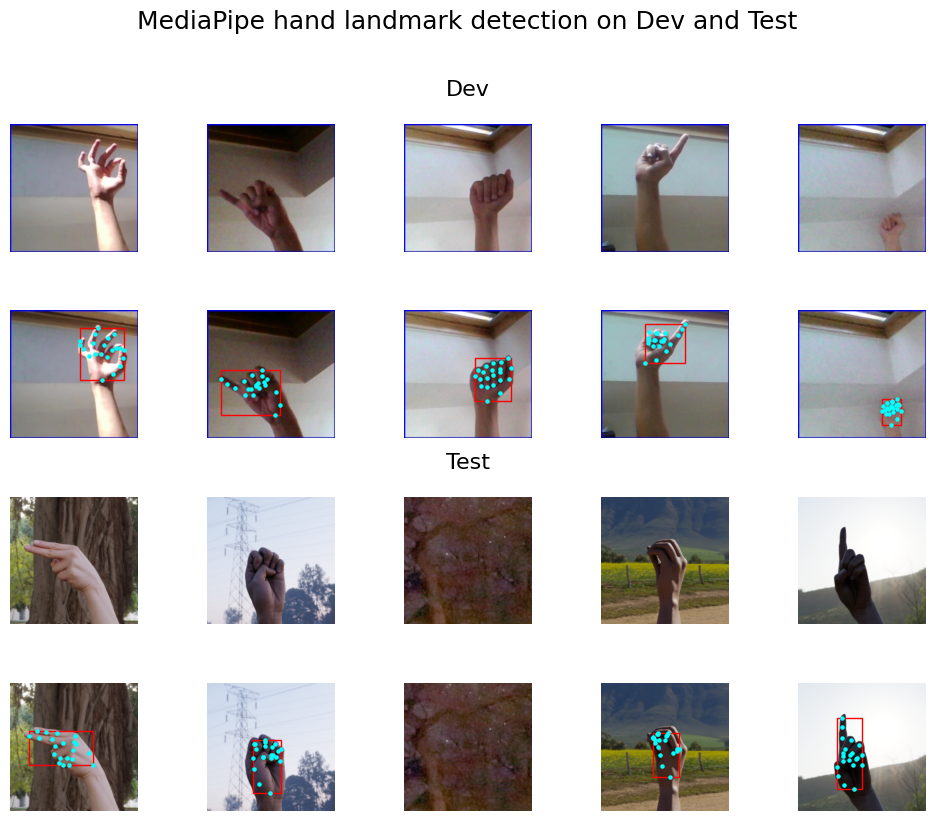

In [2]:
random.seed(22)
np.random.seed(22)

dev_sample = random.sample(dev_paths, 5)
test_sample = random.sample(test_paths, 5)

# set up MediaPipe
mp_hands = mp.solutions.hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.1,
    min_tracking_confidence=0.1,
    model_complexity=0
)

n_cols = len(dev_sample)
fig, axs = plt.subplots(4, n_cols, figsize=(n_cols * 2, 8), sharex=True, sharey=True)

# remove gaps
plt.subplots_adjust(wspace=0.05, hspace=0.05)


def load_and_resize(path):
    pil = Image.open(path).convert("RGB")
    pil = pil.resize((256, 256), Image.BILINEAR)
    return np.array(pil)


def annotate(img, ax):
    res = mp_hands.process(img)
    if res.multi_hand_landmarks:
        lm = res.multi_hand_landmarks[0]
        h, w, _ = img.shape
        pts = np.array([[p.x * w, p.y * h] for p in lm.landmark])
        x1, y1 = pts[:, 0].min(), pts[:, 1].min()
        x2, y2 = pts[:, 0].max(), pts[:, 1].max()
        ax.add_patch(Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor="red", linewidth=1))
        ax.scatter(pts[:, 0], pts[:, 1], c="cyan", s=5)


# fill in the grid
for i, path in enumerate(dev_sample):
    img = load_and_resize(path)
    axs[0, i].imshow(img)
    axs[0, i].axis('off')
    axs[0, i].set_aspect('equal')
    axs[1, i].imshow(img)
    annotate(img, axs[1, i])
    axs[1, i].axis('off')
    axs[1, i].set_aspect('equal')

for i, path in enumerate(test_sample):
    img = load_and_resize(path)
    axs[2, i].imshow(img)
    axs[2, i].axis('off')
    axs[2, i].set_aspect('equal')
    axs[3, i].imshow(img)
    annotate(img, axs[3, i])
    axs[3, i].axis('off')
    axs[3, i].set_aspect('equal')

# Section titles
mid = n_cols // 2
axs[0, mid].set_title('Dev', fontsize=16, pad=20)
axs[2, mid].set_title('Test', fontsize=16, pad=20)

# Row labels in first column
axs[0, 0].set_ylabel('Original', fontsize=12, rotation=90, labelpad=10)
axs[1, 0].set_ylabel('Annotated', fontsize=12, rotation=90, labelpad=10)
axs[2, 0].set_ylabel('Original', fontsize=12, rotation=90, labelpad=10)
axs[3, 0].set_ylabel('Annotated', fontsize=12, rotation=90, labelpad=10)

fig.suptitle(
    'MediaPipe hand landmark detection on Dev and Test',
    fontsize=18,
    y=1.02  # push it up above the subplots
)
plt.tight_layout()
plt.show()

#### The pipeline

Display the underlying sklearn pipeline

In [3]:
pipe = HybridPipeline()
pipe.plot_pipeline()

I0000 00:00:1746972152.491333 13321444 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4 Pro


Pipeline(steps=[('mp',
                 <HybridPipeline.MPFeatureExtractor object at 0x38c7f2850>),
                ('clf',
                 RandomForestClassifier(max_depth=10, n_jobs=13,
                                        random_state=42))])

#### Training

In [4]:
pipe.fit(train_paths, train_labels)
print("Trained HybridPipeline on train")

Extracting hand landmarks: 100%|██████████| 75428/75428 [16:15<00:00, 77.33it/s]


Trained HybridPipeline on train


#### Evaluate on dev

Extracting hand landmarks: 100%|██████████| 11600/11600 [02:29<00:00, 77.68it/s]


### DEV SET ###
Accuracy     : 0.7964
Macro-F1     : 0.8425


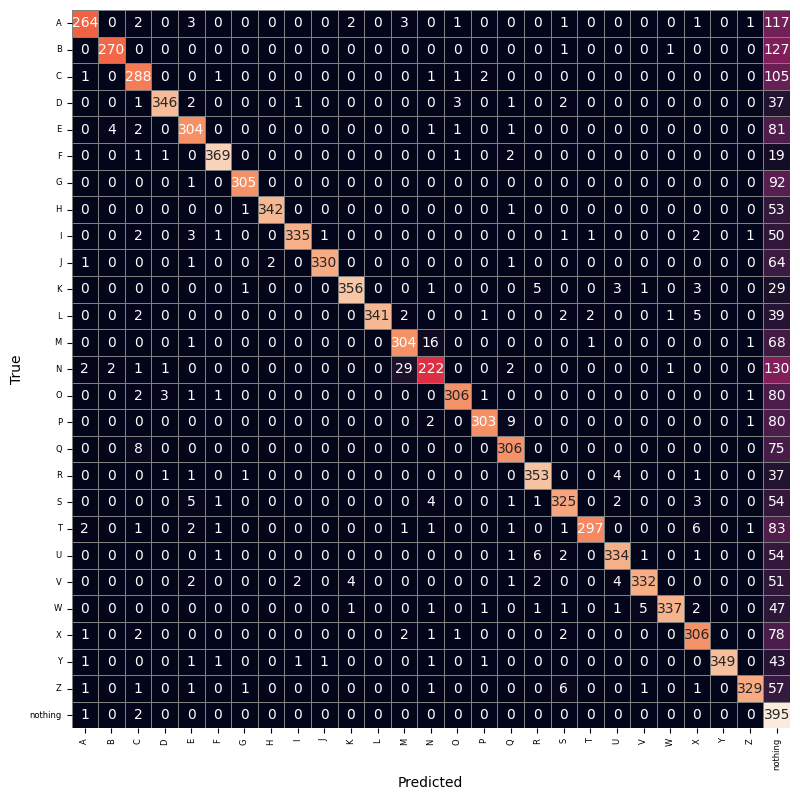

In [9]:
dev_metrics = pipe.evaluate(dev_paths, dev_labels)

print("### DEV SET ###")
print(f"Accuracy     : {dev_metrics['accuracy']:.4f}")
print(f"Macro-F1     : {dev_metrics['f1_macro']:.4f}")

plot_cm_subset(dev_metrics['cm'], classes, subset_to_plot)

#### Evaluate on test

Extracting hand landmarks: 100%|██████████| 2700/2700 [00:43<00:00, 61.74it/s]


### TEST SET ###
Accuracy     : 0.3781
Macro-F1     : 0.3606


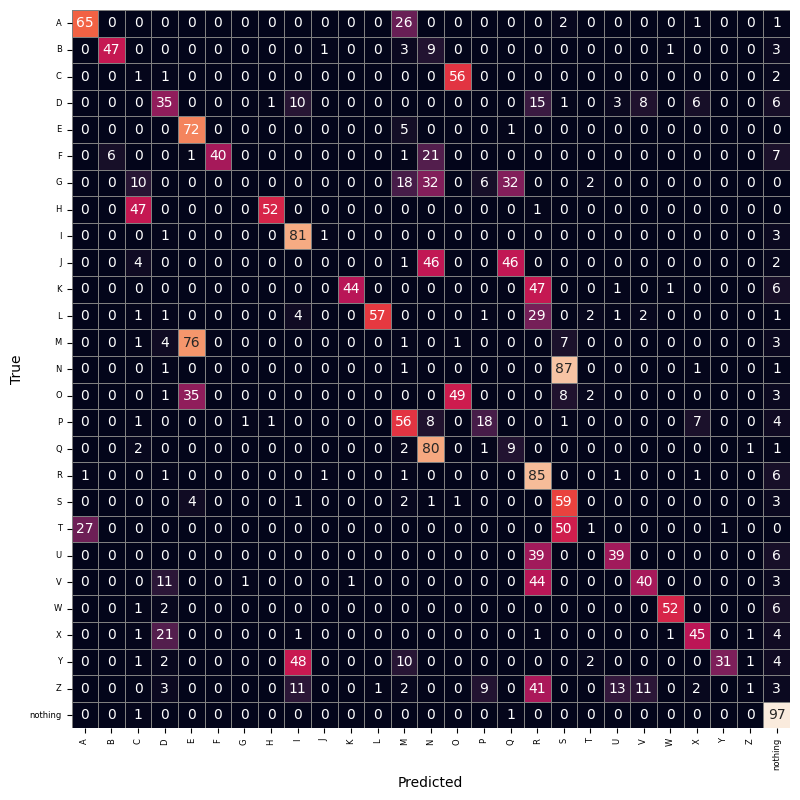

In [10]:
test_metrics = pipe.evaluate(test_paths, test_labels)

print("### TEST SET ###")
print(f"Accuracy     : {test_metrics['accuracy']:.4f}")
print(f"Macro-F1     : {test_metrics['f1_macro']:.4f}")

plot_cm_subset(test_metrics['cm'], classes, subset_to_plot)

#### Save model

In [11]:
out = Path('../models') / 'hybrid_pipeline.pkl'
out.parent.mkdir(exist_ok=True, parents=True)
pipe.save(str(out))
print(f"Saved HybridPipeline to {out}")

Saved HybridPipeline to ../models/hybrid_pipeline.pkl


#### Load Model and evaluate again

In [8]:
pipe2 = HybridPipeline().load(str(out))
print(f"Loaded pipeline from {out}\n")

# 1) Eval on DEV
dev_metrics = pipe2.evaluate(dev_paths, dev_labels)
print("### DEV SET (reloaded) ###")
print(f"Accuracy     : {dev_metrics['accuracy']:.4f}")
print(f"Macro-F1     : {dev_metrics['f1_macro']:.4f}")

# 2) Eval on TEST
test_metrics = pipe2.evaluate(test_paths, test_labels)
print("### TEST SET (reloaded) ###")
print(f"Accuracy     : {test_metrics['accuracy']:.4f}")
print(f"Macro-F1     : {test_metrics['f1_macro']:.4f}")

I0000 00:00:1746973321.689525 13321444 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4 Pro
I0000 00:00:1746973321.701157 13321444 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4 Pro


Loaded pipeline from ../models/hybrid_pipeline.pkl



Extracting hand landmarks: 100%|██████████| 11600/11600 [02:27<00:00, 78.60it/s]


### DEV SET (reloaded) ###
Accuracy     : 0.7964
Macro-F1     : 0.8425


Extracting hand landmarks: 100%|██████████| 2700/2700 [00:43<00:00, 61.96it/s]

### TEST SET (reloaded) ###
Accuracy     : 0.3781
Macro-F1     : 0.3606
